In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pickle

In [2]:

 

# Import h= (yaw,pitch)
with open("/content/drive/My Drive/h_list.txt", "rb") as fp:   # Unpickling
    h = pickle.load(fp)

# Import fl
with open("/content/drive/My Drive/features_left512.txt", "rb") as fp:   # Unpickling
    features_left = pickle.load(fp)

# Import fr
with open("/content/drive/My Drive/features_right512.txt", "rb") as fp:   # Unpickling
    features_right = pickle.load(fp)

# Import target gaze
with open("/content/drive/My Drive/gaze.txt", "rb") as fp:   # Unpickling
    gazes = pickle.load(fp)

# Import left eye images
with open("/content/drive/My Drive/l_imgs.txt", "rb") as fp:   # Unpickling
    l_imgs = pickle.load(fp)


# Import right eye images
with open("/content/drive/My Drive/r_imgs.txt", "rb") as fp:   # Unpickling
    r_imgs = pickle.load(fp)

In [4]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as patches
import math
from math import *
from torch.utils.data import Dataset
import torchvision
import torch.optim as optim
from torchvision import models 
from torchvision import transforms
import torch.nn as nn
from PIL import Image
from matplotlib import cm
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data preparation and concatenation

In [3]:
#l operator = {0,1} 0 if eyes are not detected, 1 if eyes are detected 
#we multiply this operator with the features extracted from the resnet
def l_op(l_imgs,r_imgs): 
    l_imgs = torch.as_tensor(np.array(l_imgs)).cuda()
    r_imgs = torch.as_tensor(np.array(r_imgs)).cuda()
    eyes_b =l_imgs.sum(axis = (3,2,1)) +r_imgs.sum(axis = (3,2,1))
    lop = (eyes_b).bool()
    lop = lop.int()
    return lop

def lop_eyes_features( lop, eyes_features):
    x= eyes_features
    for i in range(len(lop)):
      x[i] = torch.mul(eyes_features[i],lop[i])
    return x

In [5]:
h2=torch.as_tensor(h).cuda()

In [6]:
gazes2=torch.as_tensor(np.array(gazes)).cuda()

In [7]:
#prepare eyes features : concatenation + multiplication with l operator 
eyes_features = torch.cat((features_right, features_left), 1)
lop = l_op(l_imgs,r_imgs)

In [8]:
# Multiply eyes features and L operator
lop_EyesFeatures = lop_eyes_features(lop,eyes_features)

In [9]:
# Concatenate eyes features with h
data_in = torch.cat((h2,lop_EyesFeatures), 1)

In [10]:
#Normalize the concatenated tensor
data_in2= data_in.clone().detach()
data_in2 = ((data_in2.T - data_in2.mean(axis = 1))/data_in2.std(axis = 1)).T

In [12]:
data_in2.shape

torch.Size([10000, 1026])

In [14]:

class MLPDataset(Dataset):
    """prep_data_for_MLP."""

    def __init__(self, data_in,gaze, transform=None):
        self.data_in = data_in
        self.target = gazes
        self.transform = transform



    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x = self.data_in[idx]
        y=  self.target[idx]
        if self.transform:
              x = self.transform(x)
        return x,y

In [16]:
preprocess = transforms.Compose([
        transforms.Lambda(lambda x: x.double()),
        ])
dataset = MLPDataset(data_in2,gazes2,transform=preprocess)

In [17]:
validation_split = .2
shuffle_dataset = True
random_seed= 42
batch_size= 128
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [18]:
#input tensor size
tensor_size= len(features_left[0])*2+len(h[0])

In [19]:
#Function to create a Pretrained Resnet Model with a Fully Connected Layer
# (out_1: ouput of 1st layer), (out_2: ouput of 2nd layer)
def createModel_MLP(hidden,tensor_size):
    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(tensor_size, hidden),
      nn.ReLU(),
      #nn.Linear(hidden, 128),
      #nn.ReLU(),
      nn.Linear(hidden, 3 ),
    )
    
    model.double() #double to set variables to double
    #Sending the device to the GPU if avaliable
    model.to(device)

    return model

Starting training
Epoch Number: 0
loss: 11.098617509833238
val loss: 2.6047674627190207
Epoch Number: 1
loss: 9.648586850031837
val loss: 2.557532906549756
Epoch Number: 2
loss: 9.578530719102773
val loss: 2.541201517978924
Epoch Number: 3
loss: 9.543880914217299
val loss: 2.5154621557068926
Epoch Number: 4
loss: 9.50878817635817
val loss: 2.5107452320892683
Epoch Number: 5
loss: 9.586014811129786
val loss: 2.5850049182363746
Epoch Number: 6
loss: 9.521385757143205
val loss: 2.508413028230408
Epoch Number: 7
loss: 9.494090997558967
val loss: 2.514394467302332
Epoch Number: 8
loss: 9.50360320101332
val loss: 2.514060974377643
Epoch Number: 9
loss: 9.482078968747215
val loss: 2.527190506573185
Epoch Number: 10
loss: 9.497353013638403
val loss: 2.59309128582563
Epoch Number: 11
loss: 9.500809323567946
val loss: 2.512597498162035
Epoch Number: 12
loss: 9.458667298517016
val loss: 2.544770093602089
Epoch Number: 13
loss: 9.502194448441045
val loss: 2.5130302150899273
Epoch Number: 14
loss: 

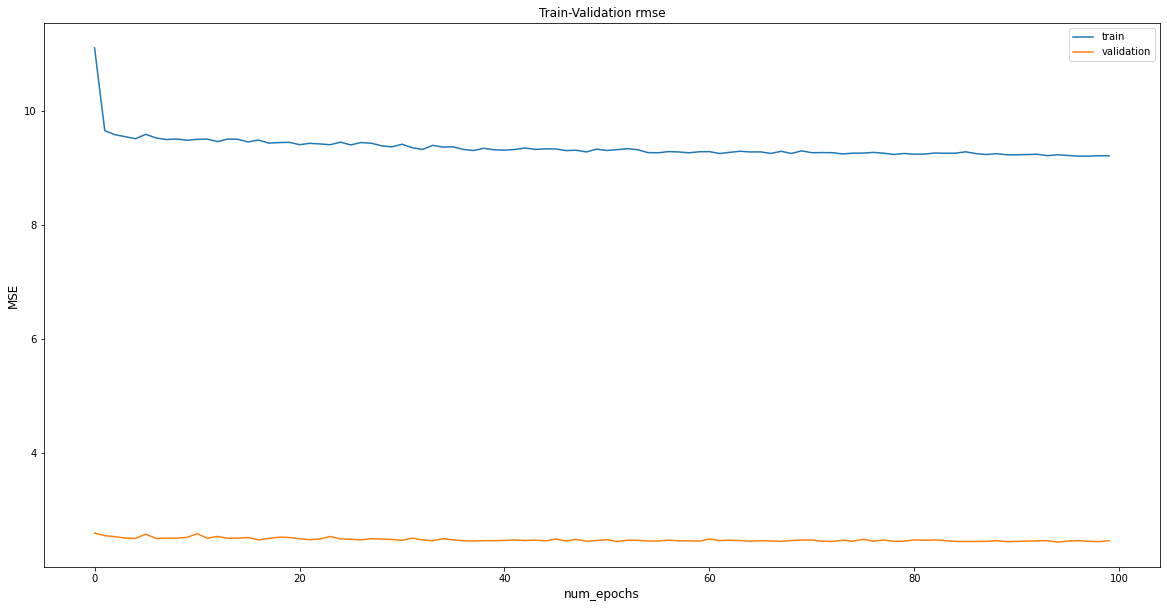

In [23]:
#Function to handle training
#(model: model to train), (criterion: loss function for the model), (optimizer, what optimizer to use)
def train(model, criterion, optimizer, file, epochs=80, trainLoss=[], validationLoss=[]):
    #device = torch.device("cpu")
    print("Starting training")
    for epoch in range(epochs):
        print(f"Epoch Number: {epoch}")

        testAccuracy = 0
        totalLoss = 0

        for i, data in enumerate(train_loader, 0):
            #Put model into training mode
            model.train()
            #batch= next(iter(train_loader))
            x=data[0]
            y=data[1].to(device)
            #Zero out gradients
            optimizer.zero_grad()
            #Make a prediction
            y_hat = model(x)
            
            #Calculate the loss
            loss = criterion(y_hat, y)
            #l = torch.sqrt(loss)
            #Update the total loss
            totalLoss += loss
            #Initiate backpropagation
            loss.backward()
            
            #Update parameters
            optimizer.step()

            #testAccuracy += (y_hat == y).sum().item()
        trainLoss.append(totalLoss)
        print(f"loss: {totalLoss}")
        
        valAccuracy = 0
        totalLoss = 0
        
        
        for j, data in enumerate(validation_loader, 0):
            # Put the model into evaluation mode
            #banch= next(iter(validation_loader))
            x=data[0]
            y=data[1].to(device)
            model.eval()
            y_pred= model(x)
            #print(y_pred)
            loss = criterion(y_pred, y)
            #l = torch.sqrt(loss)
            totalLoss += loss
        print(f"val loss: {totalLoss}")
        validationLoss.append(totalLoss)
        #Save our model for each epoch
    fig = plt.figure(figsize=(20,10))
    plt.title("Train-Validation rmse")
    plt.plot(trainLoss, label='train')
    plt.plot(validationLoss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('MSE', fontsize=12)
    plt.legend(loc='best')
    plt.savefig('MLP_MSE_normalized1026.png')
    plt.savefig("/content/drive/MyDrive/"+'MLP_MSE_normalized1026.png')

    torch.save(model.state_dict(), file)
    torch.save(model.state_dict(), "/content/drive/MyDrive/"+file)
    return trainLoss, validationLoss, model

#Create a model using our function
model = createModel_MLP(256,tensor_size)
#Define our loss and optimizers
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
#Specify output file name
file = "MLP.pth" #save model

#Try to use Colab's GPU here, otherwise it will take a long time to train.
output = train(model, criterion, optimizer, file,epochs= 100)